# Hospital Inpatient Discharges (SPARCS De-identified): 2017
Source: New York State Health Department
https://health.data.ny.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/22g3-z7e7

Goal is to predict Risk of Mortality to better inform treatment, aggresivness of approach, expectations of family...

In [129]:
import pandas as pd
import numpy as np

In [3]:
# Using Hospital Inpatient Discharge information for the State of New York from 2017

df= pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017.csv')

/Users/stevenchase/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(df.shape)
df.head()

(2343569, 34)


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Medicare,Self-Pay,NaN,N,N,114168.00,40464.04
1,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,58517.00,26046.50
2,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,...,Moderate,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,39647.04,17397.59
3,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,36031.09,16118.84
4,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,...,Minor,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,30534.00,11921.05


## Exploration of target

**The target that I want to predict is APR Risk of Mortality.**

This is an important target as it will dictate certain decisions such as treatments, aggresiveness of care, familial preparations for the worst outcome etc...
- Ordinal rank Minor(1), Moderate(2), Major(3), Extreme(4)

In [8]:
# Ordinal encode
df['APR Risk of Mortality'] = df['APR Risk of Mortality'].replace({
    'Minor': 1,
    "Moderate": 2,
    "Major": 3,
    "Extreme": 4
})

In [9]:
# Target is 'APR Risk of Mortality'

# Look at target distribution
df['APR Risk of Mortality'].describe()

count    2.343329e+06
mean     1.691481e+00
std      9.164827e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: APR Risk of Mortality, dtype: float64

In [10]:
# Value counts

df['APR Risk of Mortality'].value_counts()

1.0    1338452
2.0     508068
3.0     378128
4.0     118681
Name: APR Risk of Mortality, dtype: int64

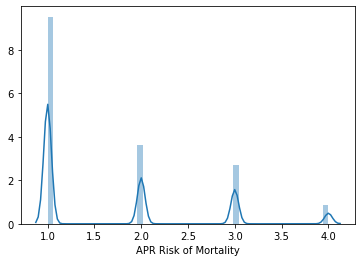

In [11]:
# Visual exploration of the column

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['APR Risk of Mortality']);

My problem is a multi-class classification

In [12]:
df['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

The majority class (1) for my target is is 57%. <br>
I will use accuracy and average f1 score as my evaluation metrics
- Average f1-scores are used for multi-class targets
- Weighted average f1-score will acocunt for the label inbalance in my target

I will use a random split to train/val/test my data as all observations are within the same year. <br>

## Feature Exploration

**Features to exclude** <br>
Not applicable to target
- Operating Certificate Number
- Patient Disposition (Destination upon discharge, I want to predict mortality risk while at the hospital. Where they were discharged afterwards isn't information I would have in the timeframe that I want to use my model.)
- Discharge year (The entire dataset is for the year 2017) 
- Total charges
- Total cost (both of these are information gathered after I would want my model to be used, not sure if they are helpful.
- Birth weight (only applicable to newborns)


Redundant: All of the codes have a description column. I will pull them out as a reference table, but for my model they are redundant.
- CCS Diagnosis Description
- CCS Procedure Description
- APR DRG Description
- APR MDC Description


Potential data leakage:
- APR Severity of Illness code (might have a direct correlation to Risk of Mortality. They are missing the exact same amount of values) - After exploring I have concluded that they are not directly related


Might want to use the below features to create an engineered feature of patient distance to hospital

- Permanent Facility Id
- Facility Name
- Hospital Service Area
- Hospital Country
- Zip code 

Some of the categories are more generic sets of other categories. For example APR DRG Classification codes fit inside APR MDC codes.
- Same with all of the geographic information.




## Reference Tables
- Matches descriptions with codes

In [83]:
# Create a reference table for codes and their descriptions
# We will be dropping the descriptions

# CCS Diagnosis
codes_diagnosis = df.groupby('CCS Diagnosis Description')['CCS Diagnosis Code'].mean()
codes_diagnosis = pd.DataFrame(codes_diagnosis)

# CCS Procedure
codes_procedure = df.groupby('CCS Procedure Description')['CCS Procedure Code'].mean()
codes_procedure = pd.DataFrame(codes_procedure)

# APR DRG
codes_drg = df.groupby('APR DRG Description')['APR DRG Code'].mean()
codes_drg = pd.DataFrame(codes_drg)

# APR MDC
codes_mdc = df.groupby('APR MDC Description')['APR MDC Code'].mean()
codes_mdc = pd.DataFrame(codes_mdc)

# APR Severity of Illness
codes_illness = df.groupby('APR Severity of Illness Description')['APR Severity of Illness Code'].mean()
codes_illness = pd.DataFrame(codes_illness)

## Initial Data Cleaning

In [49]:
# Change pandas display so you can see all of the columns at once

pd.set_option('display.max_columns', 25)

In [71]:
# Drop unnecessary features as commented above

df_cleaned = df.drop([
    'Operating Certificate Number',
    'Patient Disposition',
    'Discharge Year',
    'CCS Diagnosis Description',
    'CCS Procedure Description',
    'APR DRG Description',
    'APR MDC Description',
    'Birth Weight',
    'Total Charges',
    'Total Costs',
    'APR Severity of Illness Description'
],
    axis= 1

)
df_cleaned.head()

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,21,Elective,659,0,750,19,2,Moderate,1.0,Medical,Medicare,Medicare,Self-Pay,N,N
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,8,Emergency,99,108,194,5,3,Major,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,6,Emergency,161,102,465,11,2,Moderate,2.0,Medical,Department of Corrections,Self-Pay,NaN,N,N
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,4,Emergency,238,222,721,18,2,Moderate,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,4,Emergency,2,0,720,18,2,Moderate,1.0,Medical,Department of Corrections,Self-Pay,NaN,N,N


In [73]:
# Look at null values
df_cleaned.isnull().sum()

Hospital Service Area                     5150
Hospital County                           5150
Permanent Facility Id                     5150
Facility Name                                0
Age Group                                    0
Zip Code - 3 digits                      39013
Gender                                       0
Race                                         0
Ethnicity                                    0
Length of Stay                               0
Type of Admission                            0
CCS Diagnosis Code                           0
CCS Procedure Code                           0
APR DRG Code                                 0
APR MDC Code                                 0
APR Severity of Illness Code                 0
APR Severity of Illness Description          0
APR Risk of Mortality                        0
APR Medical Surgical Description             0
Payment Typology 1                           0
Payment Typology 2                      878621
Payment Typol

In [72]:
# Drop missing values in target (only 0.01%)
df_cleaned.dropna(subset= ['APR Risk of Mortality'], inplace= True)

## Data exploration 

In [53]:
# Look at numeric traits
df_cleaned.describe()

,Permanent Facility Id,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,2.338414e+06,2.343569e+06,2.343569e+06,2.343569e+06,2.343569e+06,2.343569e+06,2.343329e+06
mean,1.038981e+03,1.898732e+02,1.013995e+02,4.161805e+02,1.031093e+01,2.020746e+00,1.691481e+00
std,7.202281e+02,1.649453e+02,8.681581e+01,2.424942e+02,5.900304e+00,8.891484e-01,9.164827e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,5.410000e+02,1.010000e+02,0.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,1.000000e+00
50%,1.097000e+03,1.570000e+02,9.800000e+01,3.830000e+02,9.000000e+00,2.000000e+00,1.000000e+00
75%,1.453000e+03,2.180000e+02,1.800000e+02,6.400000e+02,1.500000e+01,3.000000e+00,2.000000e+00
max,9.431000e+03,2.617000e+03,2.310000e+02,9.560000e+02,2.500000e+01,4.000000e+00,4.000000e+00


In [54]:
# Look at categorical traits
df_cleaned.describe(exclude= 'number')

,Hospital Service Area,Hospital County,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR Severity of Illness Description,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,2338414,2338414,2343569,2343569,2304550,2343569,2343569,2343569,2343569,2343569,2343329,2343569,2343569,1464847,606325,2343569,2343569
unique,8,57,211,5,50,3,4,4,120,6,4,3,10,10,10,2,2
top,New York City,Manhattan,Mount Sinai Hospital,70 or Older,112,F,White,Not Span/Hispanic,2,Emergency,Moderate,Medical,Medicare,Medicaid,Self-Pay,N,Y
freq,1070546,395717,52335,664780,293867,1296954,1317040,1895664,546125,1500465,905106,1742760,906903,529741,400996,2340218,1373740


In [55]:
# Look at null values, we will need to impute in the future
df_cleaned.isnull().sum()

Hospital Service Area                     5155
Hospital County                           5155
Permanent Facility Id                     5155
Facility Name                                0
Age Group                                    0
Zip Code - 3 digits                      39019
Gender                                       0
Race                                         0
Ethnicity                                    0
Length of Stay                               0
Type of Admission                            0
CCS Diagnosis Code                           0
CCS Procedure Code                           0
APR DRG Code                                 0
APR MDC Code                                 0
APR Severity of Illness Code                 0
APR Severity of Illness Description        240
APR Risk of Mortality                      240
APR Medical Surgical Description             0
Payment Typology 1                           0
Payment Typology 2                      878722
Payment Typol

## Split into train/val/test using random split

In [77]:
from sklearn.model_selection import train_test_split

# Split train data into train and test, 80/20 split

train, test = train_test_split(df_cleaned, train_size=0.85, test_size=0.15, 
                              stratify=df_cleaned['APR Risk of Mortality'], random_state=42)

# Then split train into train and validate
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['APR Risk of Mortality'], random_state=42)

train.shape, val.shape, test.shape

((1593463, 24), (398366, 24), (351500, 24))

## Baseline model: 
Majority class (1, minor risk) is 57%

In [79]:
df_cleaned['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

In [109]:
# Baseline classification report
# Looking at weighted average f1-score as an evaluation metric 
guess= [1] * len(train)

print(classification_report(y_train, guess))

              precision    recall  f1-score   support

         1.0       0.57      1.00      0.73    910147
         2.0       0.00      0.00      0.00    345486
         3.0       0.00      0.00      0.00    257127
         4.0       0.00      0.00      0.00     80703

    accuracy                           0.57   1593463
   macro avg       0.14      0.25      0.18   1593463
weighted avg       0.33      0.57      0.42   1593463



## First Model

In [87]:
# Set features and target
# Define target vector and feature matrices

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Severity of Illness Code',
    'APR Medical Surgical Description',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [100]:
!pip install category_encoders==2

     |████████████████████████████████| 87 kB 854 kB/s eta 0:00:01


In [110]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(max_depth= 10, n_estimators= 10)
)

# Fit on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.7645555623193008
Validation Accuracy: 0.7634436673812525


#### First model evaluation metric results
Train Accuracy: 0.7800501172603317 <br>
Validation Accuracy: 0.7783646194705371

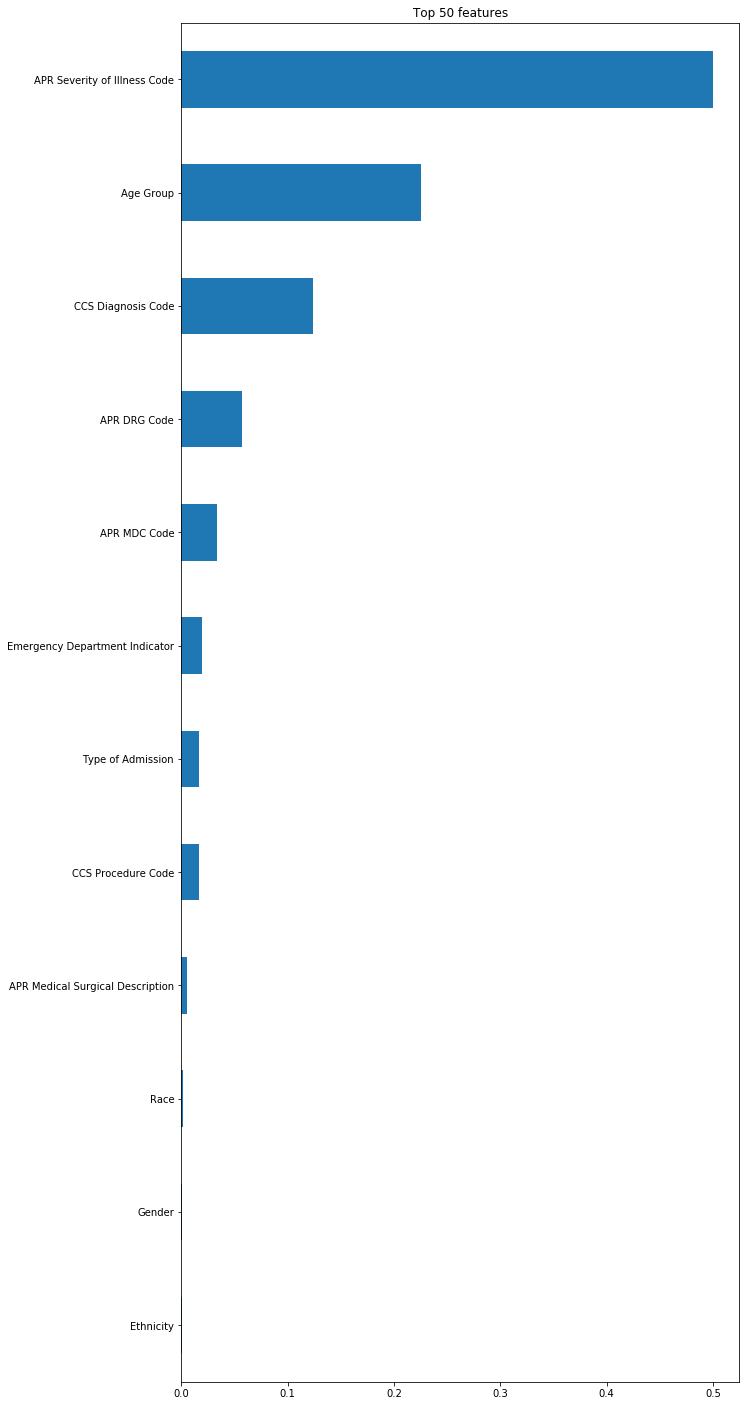

In [102]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

### Confusion Matrix

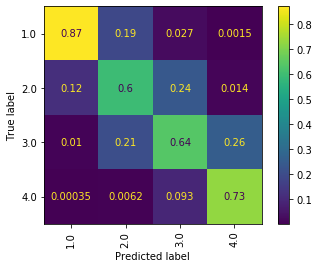

In [103]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix

# Plot
plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation= 'vertical', normalize= 'pred')

# Enlarge
plt.rcParams['figure.dpi']= 200

### Scores for Model 1

In [111]:
# Look at precision and recall for each class
# Using weighted average f1-score as an evaluation metric

from sklearn.metrics import classification_report

# Make predictions
y_pred= pipeline.predict(X_val)

# Print scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.86      0.93      0.89    227537
         2.0       0.59      0.43      0.50     86371
         3.0       0.60      0.71      0.65     64282
         4.0       0.78      0.45      0.57     20176

    accuracy                           0.76    398366
   macro avg       0.71      0.63      0.65    398366
weighted avg       0.75      0.76      0.75    398366



Remember that the baseline model had an accuracy of 57% with a weighted average f1-score of 0.42

## Model 2
- Include all of the features except for geographic data

In [125]:
# Look at label names for spelling mistakes etc...
df_cleaned['Emergency Department Indicator'].value_counts().index.tolist()

['Y', 'N']

In [126]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Length of Stay',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Severity of Illness Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Payment Typology 2',
    'Payment Typology 3',
    'Abortion Edit Indicator',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [127]:
# Create a function to clean data the same way

def clean(X):
    
# Prevent SettingWithCopyWarning - create a copy
    X = X.copy()
    
# Replace missing values of Payment Typology 2 and 3 with 'None', they only used one type of payment
    X['Payment Typology 2']= X['Payment Typology 2'].replace({np.nan: 'None'})
    X['Payment Typology 3']= X['Payment Typology 3'].replace({np.nan: 'None'})

# Return cleaned dataset    
    return X

In [130]:
# Clean train, val, test 

X_train= clean(X_train)

X_val= clean(X_val)

X_test= clean(X_test)

In [131]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(max_depth= 10, n_estimators= 10)
)

# Fit on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.7802201871019283
Validation Accuracy: 0.7789946933222213


### Scores for Model 2

In [132]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.88      0.93      0.90    227537
         2.0       0.59      0.50      0.54     86371
         3.0       0.64      0.68      0.66     64282
         4.0       0.73      0.66      0.69     20176

    accuracy                           0.78    398366
   macro avg       0.71      0.69      0.70    398366
weighted avg       0.77      0.78      0.77    398366



Including all of the features barely changed the evaluation scores

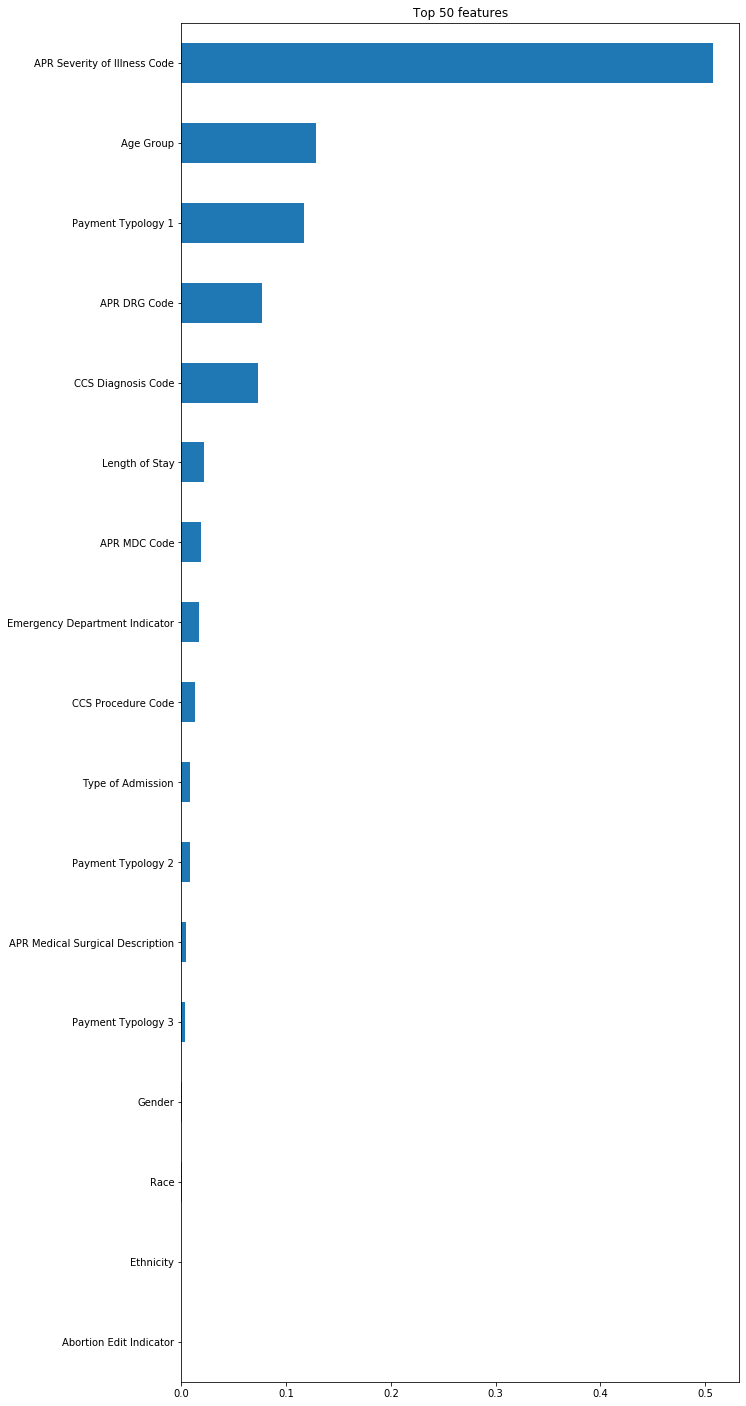

In [133]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

## Model 3
- Feature engineer: distance to hospital
- Feature engineer: did they require multiple methods of payment
- Clean up feature selection. Don't include ones that have low importance in the model or are more generic categories of others (MDC code is more general version of DRG code)

In [141]:
df_cleaned.head()

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,21,Elective,659,0,750,19,2,Moderate,1.0,Medical,Medicare,Medicare,Self-Pay,N,N
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,8,Emergency,99,108,194,5,3,Major,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,6,Emergency,161,102,465,11,2,Moderate,2.0,Medical,Department of Corrections,Self-Pay,NaN,N,N
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,4,Emergency,238,222,721,18,2,Moderate,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,4,Emergency,2,0,720,18,2,Moderate,1.0,Medical,Department of Corrections,Self-Pay,NaN,N,N


In [140]:
df_cleaned.describe(exclude= 'number')

,Hospital Service Area,Hospital County,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR Severity of Illness Description,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,2338179,2338179,2343329,2343329,2304316,2343329,2343329,2343329,2343329,2343329,2343329,2343329,2343329,1464708,606295,2343329,2343329
unique,8,57,211,5,50,3,4,4,120,6,4,2,10,10,10,2,2
top,New York City,Manhattan,Mount Sinai Hospital,70 or Older,112,F,White,Not Span/Hispanic,2,Emergency,Moderate,Medical,Medicare,Medicaid,Self-Pay,N,Y
freq,1070407,395687,52335,664780,293826,1296822,1316956,1895507,546084,1500436,905106,1742545,906899,529653,400972,2339978,1373723


In [139]:
df_cleaned.describe()

,Permanent Facility Id,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,2.338179e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06
mean,1.038966e+03,1.898662e+02,1.013940e+02,4.161252e+02,1.031172e+01,2.020953e+00,1.691481e+00
std,7.202033e+02,1.649466e+02,8.681344e+01,2.424451e+02,5.899823e+00,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.410000e+02,1.010000e+02,0.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,1.000000e+00
50%,1.097000e+03,1.570000e+02,9.800000e+01,3.830000e+02,9.000000e+00,2.000000e+00,1.000000e+00
75%,1.453000e+03,2.180000e+02,1.800000e+02,6.400000e+02,1.500000e+01,3.000000e+00,2.000000e+00
max,9.431000e+03,2.617000e+03,2.310000e+02,9.520000e+02,2.500000e+01,4.000000e+00,4.000000e+00


In [138]:
df_cleaned.isnull().sum()

Hospital Service Area                     5150
Hospital County                           5150
Permanent Facility Id                     5150
Facility Name                                0
Age Group                                    0
Zip Code - 3 digits                      39013
Gender                                       0
Race                                         0
Ethnicity                                    0
Length of Stay                               0
Type of Admission                            0
CCS Diagnosis Code                           0
CCS Procedure Code                           0
APR DRG Code                                 0
APR MDC Code                                 0
APR Severity of Illness Code                 0
APR Severity of Illness Description          0
APR Risk of Mortality                        0
APR Medical Surgical Description             0
Payment Typology 1                           0
Payment Typology 2                      878621
Payment Typol